In [1]:
from model.functions import counter_word
from model.preprocessing import RemovePunctuations, RemoveStopWords, TextToSequence, PadSequences
from model.attention import Attention

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Concatenate, Dense, LSTM, Dropout, Bidirectional

import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pickle

[nltk_data] Downloading package stopwords to C:\Users\Harshana
[nltk_data]     Lakmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
warnings.filterwarnings("ignore")

In [3]:
tf.__version__

'2.16.1'

In [4]:
df = pd.read_csv("Data/Full Data.csv")
df = df.sample(frac=1, random_state=42)

In [5]:
train_size = int(df.shape[0] * 0.8)

training_data = df[:train_size]
testing_data = df[train_size:]

X_train = training_data["text"].values
Y_train = training_data["label"].values

X_test = testing_data["text"].values
Y_test = testing_data["label"].values

In [6]:
stop = set(stopwords.words("english"))

In [7]:
pipe = Pipeline(
    steps=[
        ("remove_punctuations", RemovePunctuations()),
        ("remove_stop_words", RemoveStopWords()),
    ]
)

In [8]:
transformed_text_values = pipe.fit_transform(X_train, Y_train)

counter = counter_word(transformed_text_values)
num_unique_words = len(counter)

tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(transformed_text_values)

word_index = tokenizer.word_index
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [9]:
preprocessing_pipe = Pipeline(
    steps=[
        ("remove_punctuations", RemovePunctuations()),
        ("remove_stop_words", RemoveStopWords()),
        ("text_to_sequences", TextToSequence(tokenizer=tokenizer)),
        ("pad_sequences", PadSequences(max_length=200)),
    ]
)

In [10]:
processed_X_train = preprocessing_pipe.fit_transform(X_train, Y_train)
processed_X_test = preprocessing_pipe.fit_transform(X_test, Y_test)

processed_X_train.shape, processed_X_test.shape

((8594, 200), (2149, 200))

In [17]:
Y_train

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [14]:
inputs = keras.Input(shape=(200,), dtype="int64", name="input_layer")
embedded_sequences = tf.keras.layers.Embedding(num_unique_words, 128, mask_zero=True, name="embedding_layer")(inputs)

lstm = Bidirectional(LSTM(32, return_sequences=True), name="bi_lstm_00")(embedded_sequences)
(lstm_, forward_h, forward_c, backward_h, backward_c) = Bidirectional(
    LSTM(32, return_sequences=True, return_state=True), name="bi_lstm_01"
)(lstm)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm_, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=inputs, outputs=output)
config = model.get_config()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 200, 128)  │  6,205,312 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_00          │ (None, 200, 64)   │     41,216 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_01          │ [(None, 200, 64), │     24,832 │ bi_lstm_00[0][0], │
│ (Bidirectional)     │ (None, 32),       │            │ not_equal[0][0]   │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ bi_lstm_01[0][1], │
│ (Concatenate)       │                   │            │ bi_lstm_01[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, 64),      │      1,311 │ bi_lstm_01[0][0], │
│ (Attention)         │ (None, 200, 1)]   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 20)        │      1,300 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,273,992 (23.93 MB)

 Trainable params: 6,273,992 (23.93 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)

In [16]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(processed_X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 45s 411ms/step - accuracy: 0.7829 - auc: 0.6157 - loss: 0.5737 - precision: 0.5492 - recall: 0.1739 - val_accuracy: 0.9570 - val_auc: 0.9773 - val_loss: 0.2433 - val_precision: 0.9266 - val_recall: 0.8584
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 358ms/step - accuracy: 0.9710 - auc: 0.9853 - loss: 0.1571 - precision: 0.9570 - recall: 0.9014 - val_accuracy: 0.9703 - val_auc: 0.9935 - val_loss: 0.0968 - val_precision: 0.9339 - val_recall: 0.9207
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 0.9913 - auc: 0.9991 - loss: 0.0343 - precision: 0.9906 - recall: 0.9668 - val_accuracy: 0.9709 - val_auc: 0.9941 - val_loss: 0.0892 - val_precision: 0.9391 - val_recall: 0.9178
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 362ms/step - accuracy: 0.9968 - auc: 0.9991 - loss: 0.0142 - precision: 0.9985 - recall: 0.9867 - val_accuracy: 0.9715 - val_auc: 0.9840 - val_loss: 0.1128 - val_precision: 0.9419 - val_recall: 0.9178
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━

In [16]:
pred_probs = model.predict(processed_X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


In [17]:
pred_results = [1 if results[0] > 0.5 else 0 for results in pred_probs]

In [18]:
conf_mat = confusion_matrix(y_true=Y_test, y_pred=pred_results, normalize="true")

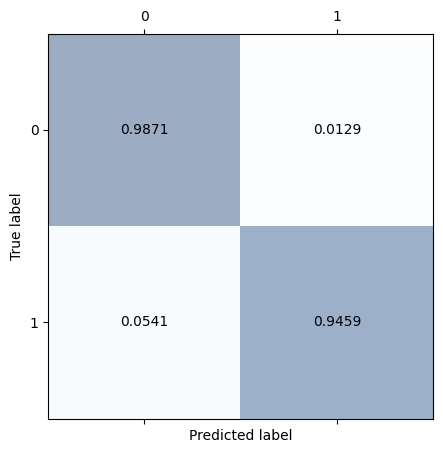

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=round(conf_mat[i, j], 4), va="center", ha="center")

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

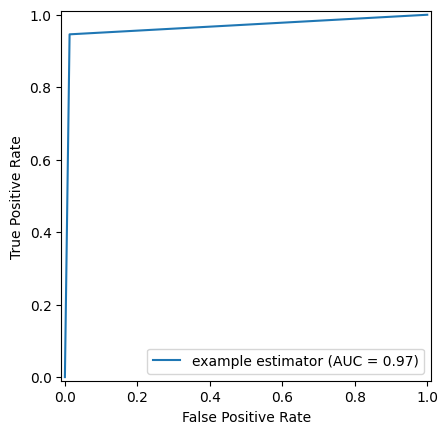

In [20]:
fpr, tpr, thresholds = roc_curve(
    Y_test,
    pred_results,
)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="example estimator")
display.plot()
plt.show()

In [23]:
pickle_objects = {"preprocessing_pipe": preprocessing_pipe, "reverse_word_index": reverse_word_index}

pickle_file = "saved_models/preprocessing.pkl"

with open(pickle_file, "wb") as f:
    pickle.dump(pickle_objects, f)

In [24]:
pred_model = keras.Model(inputs=inputs, outputs=model.get_layer(index=5).output)

In [25]:
model.save("saved_models/classification_model.keras")
pred_model.save("saved_models/attention_model.keras")